/var/folders/52/sd61j0_x1x153hyjrf4rzfyh0000gn/T/ipykernel_14833/1099217538.py:45: RuntimeWarning: divide by zero encountered in log
  log_likelihood_H1 = np.log(likelihood)
/var/folders/52/sd61j0_x1x153hyjrf4rzfyh0000gn/T/ipykernel_14833/1099217538.py:51: RuntimeWarning: divide by zero encountered in log
  log_likelihood2 += np.log(norm.pdf(v2[:,sensor], v_observed[sensor], 0.2))


The difference in log-likelihood is: 744.5388678074261
The two most likely earthquake locations are:  [1024 1726]
x1, y1 =  0.2743433190292394 0.4322958978570361
x2, y2 =  -0.842216165553134 0.18825761732523844
Probability of earthquake 1:  0.27681389017817937
Probability of earthquake 2:  0.4471436940323536


<Figure size 1000x800 with 0 Axes>

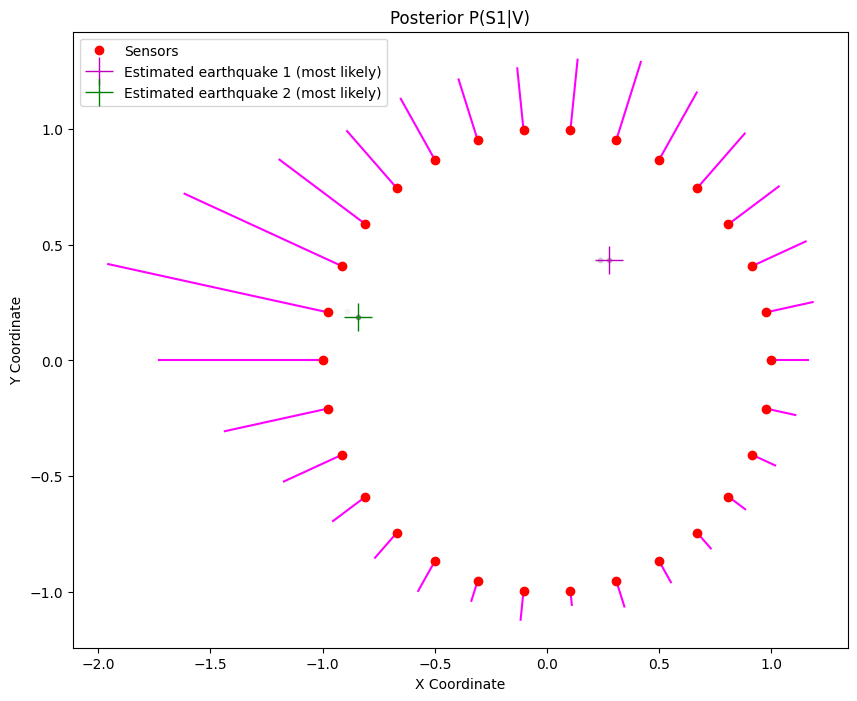

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def value(x_true, y_true, x_sensor, y_sensor):
    #Defines the likelihood of a sensor reading based on the true location of an earthquake
    return 1 / (0.1 + (x_true - x_sensor)**2 + (y_true - y_sensor)**2)

def earthquake(v_observed):
    #Define the coordinate system:
    S = 2000  # number of points on the spiral
    theta = 55 * 2 * np.pi * np.arange(S) / S
    r = np.arange(S) / S
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    #Define the locations of the detection stations on the surface
    N = len(v_observed) 
    theta_sensor = 2 * np.pi * np.arange(N) / N
    x_sensor = np.cos(theta_sensor)
    y_sensor = np.sin(theta_sensor)

    #For 1 earthquake: calculate the explosion values for the sensors = estimated values: 1 EARTHQUAKE
    v2 = np.zeros((S, N))
    for sensor in range(N):
        for s1 in range(S):
            v2[s1, sensor] = value(x[s1], y[s1], x_sensor[sensor], y_sensor[sensor])

    #For 2 earthquakes: calculate the explosion values for the sensors = estimated values
    v = np.zeros((S, S, N))
    for sensor in range(N):
        for s1 in range(S):
            for s2 in range(S):
                v[s1, s2, sensor] = value(x[s1], y[s1], x_sensor[sensor], y_sensor[sensor]) + value(x[s2], y[s2], x_sensor[sensor], y_sensor[sensor])
    
    #Perform inference p(location|observed sensor values) given these sensor values
    #P(V|S1,S2)            
    likelihood = np.ones((S,S)) 
    for sensor in range(N):
        #How likely is it a certain sensor to observe that value in a normal distr with the specified mean and standard deviation
        likelihood[:, :] *= norm.pdf(v[:,:,sensor], v_observed[sensor], 0.2) 
    summation_s2 = np.sum(likelihood,axis = 0) #marginalise out earthquake 2: geeft P(v|s1)

#------------------QUESTION 1.22.2----------------------- 
    log_likelihood_H1 = np.log(likelihood)

    # P(V|S1)
    log_likelihood2 = np.zeros(S)  # Initialize as zeros for log-sum
    for sensor in range(N):
        # Calculate the log of the normal PDF instead of the PDF itself to prevent underflow
        log_likelihood2 += np.log(norm.pdf(v2[:,sensor], v_observed[sensor], 0.2))

    #Preventing overflowing
    def log_sum_exp(log_probs):
        max_log_prob = np.max(log_probs)
        return max_log_prob + np.log(np.sum(np.exp(log_probs - max_log_prob)))
    
    total_log_likelihood_H1 = log_sum_exp(log_likelihood_H1)
    total_log_likelihood_H2 = log_sum_exp(log_likelihood2)

    #Diff in logs
    log_likelihood_difference = total_log_likelihood_H1 - total_log_likelihood_H2

    print("The difference in log-likelihood is:", log_likelihood_difference)

#-------------------------------------------------------- 

    #P(S1|V)
    posterior = summation_s2   / np.sum(summation_s2) #denominator is P(V)

    #Finding indices of the two most likely earthquake loc
    max_idx = np.argsort(posterior)[-2:]
    
    print("The two most likely earthquake locations are: ", max_idx )
    print("x1, y1 = ", x[max_idx[0]], y[max_idx[0]])
    print("x2, y2 = ", x[max_idx[1]], y[max_idx[1]])
    print("Probability of earthquake 1: ", posterior[max_idx[0]])
    print("Probability of earthquake 2: ", posterior[max_idx[1]])

    #Plotting
    cmap = plt.cm.gray_r 
    plt.figure(figsize=(10, 8))
    plt.figure(figsize=(10, 8))
    for i in range(S):
        color = cmap(posterior[i])  #Mapping the normalized probability to a color
        plt.plot(x[i], y[i], ".", color=color)

    for sensor in range(N):
    #Normalizing the line length to the observed data
        line_length = v_observed[sensor] / np.max(v_observed)
        plt.plot([x_sensor[sensor], x_sensor[sensor] * (1 + line_length)],
                [y_sensor[sensor], y_sensor[sensor] * (1 + line_length)],
                color='magenta')

    
    plt.plot(x_sensor, y_sensor, "ro", label="Sensors")
    plt.plot(x[max_idx[0]], y[max_idx[0]], "m+", markersize=20, label="Estimated earthquake 1 (most likely)")
    plt.plot(x[max_idx[1]], y[max_idx[1]], "g+", markersize=20, label="Estimated earthquake 2 (most likely)")
    plt.legend()
    plt.title('Posterior P(S1|V)')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()


    return max_idx

with open("EarthquakeExerciseData.txt") as f:
    lines = f.readlines()
v_observed = [float(line.strip()) for line in lines]

max_idx = earthquake(v_observed)

